# 1 Imports

In [20]:
# Tools
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import trange
import glob
import pickle
import gc

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Music Related
import IPython.display as ipd
import pypianoroll
from music21 import converter, instrument, note, chord,stream

# Modeling
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,GlobalAveragePooling1D,AveragePooling1D,GlobalMaxPooling1D,BatchNormalization,Activation,Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras_radam import RAdam
from sklearn.datasets import california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, KFold,cross_val_score,StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from keras_radam import RAdam

# Custom Functions
import sys
sys.path.append('./code')
from helper import sample,plot_confusion_matrix,various_scores, plot_song_composition, plot_genre_composition, plot_song_progression, plot_genre_progression
from play_midi import play_music1, play_music

# 2 Processing Midi Files

## 2.1 Load all Midi Files

In [12]:
import py_midicsv
import os

# Load file names
filenames = os.listdir('data/midi')
if '.DS_Store' in filenames:
    filenames.remove('.DS_Store')

# Remove Unnecessary Strings
filenames_clean = filenames.copy()
for ix,file in enumerate(filenames_clean):
    filenames_clean[ix] = filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    filenames_clean[ix] = filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')

# Generate Pandas Dataframe with filenames and CSV version of MIDI files
csvs = []
music_type = []
for filename in filenames:
    csvs.append(py_midicsv.midi_to_csv('data/midi/'+filename))
df_edm = pd.DataFrame({'filenames':filenames,'filenames_clean':filenames_clean,'csvs':csvs})
df_edm['filenames_clean2'] = df_edm['filenames_clean'].copy()
df_edm['filenames_clean2'] = df_edm['filenames_clean2'].apply(lambda x:x.upper())
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

## 2.2 Merge Multiple Melodies into One Melody for Each Song

In [ ]:
#!pip install pypianoroll
import pypianoroll

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
#melody,bass,drum = [[0]*128],[[0]*128],[[0]*128]
melody,bass,drum = [],[],[]

for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
#for ix,song in enumerate([df_edm['filenames'].iloc[18]]): # Play a single song
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])

## 2.3 Align Songs to have Same Mean Note as the First Song

In [1210]:
# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i][2:]))
    bass_compiled = np.concatenate((bass_compiled,bass[i][2:]))
    drum_compiled = np.concatenate((drum_compiled,drum[i][2:]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks[1].pianoroll = bass_compiled
blank_midi.tracks[2].pianoroll = drum_compiled

# Save to midi file and play
pypianoroll.write(blank_midi,'midi/compiled_adj_with_classic.mid')
#play_music("compiled_adj_with_classic.mid")

## 2.4 Create 6 Semitones of Compilation of Adjusted Songs

In [1211]:
# Create compiled midi's all 6 semitones. Trying 12 semitones with long classic music didnt work...
blank_midi = pypianoroll.Multitrack('midi/compiled_adj_with_classic.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
blank_midi.tracks[0].pianoroll = semitone_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/semitone_adj_with_classic.mid')
#play_music("semitone.mid")

# 3 Modeling

## 3.1 Prepare  Training Data and Input for LSTM

In [ ]:
# #!pip install music21
from music21 import converter, instrument, note, chord,stream

# Melody Portion
notes = []
for file in glob.glob("semitone_6_adj_with_classic.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

# Pickle save notes
pickle.dump( notes, open( "notes_semitone_6_classic.pkl", "wb" ) )
# Load notes
notes = pickle.load( open( "notes_semitone_6_classic.pkl", "rb" ) )

# Just Melody
sequence_length = 3
n_vocab = len(list(set(notes)))

# get all pitch names
pitchnames = sorted(set(item for item in notes))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)



## 3.2 Set up LSTM Architecture and Train

In [ ]:
# Define and Compile LSTM Architecture
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath = "weights_drum/100_notes_drum{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=4000, batch_size=128, callbacks=callbacks_list)

# 4 Song Generation

## 4.1 Load and Generate Melody

### 4.1.1 Setup LSTM Architecture to Load Weights

In [120]:
from music21 import converter, instrument, note, chord,stream

#Classic 6 semi
model_weight = 'weights/classic_3steps_6semitone_adj2065-1.1360-bigger.hdf5' 
notes = pickle.load( open( "notes_semitone_6_classic.pkl", "rb" ) )

sequence_length = 3
n_vocab = len(list(set(notes)))
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the weights
model.load_weights(model_weight)

### 4.1.2 Generate Melody

In [27]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []

# generate 300 notes
#temperatures = np.arange(1.1,1.4,0.1) #Worked well with 3 ntoes np.arange(1,1.3,0.1)
#temperatures = np.arange(1.3,1.8,0.1)  #worked well with 7 notes
#temperatures = [0.9,1.1,1.3,1.8,2]
#temperatures = [x-0.07  for x in temperatures]
temperatures = [1.4]
for note_index in trange(300):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    #temperature = np.random.choice(temperatures,p=[0.7,0.15,0.1,0.04,0.01])
    index = sample(prediction[0],temperatures)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.4,0.8]
    offset += np.random.choice(offsets,p=[0.96,0.04])
# Save midi file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/melody_output.mid')

# # Listen to Generated Melody
# play_music('midi/melody_output.mid')

## 4.2 Load and Generate Drum

### 4.2.1 Setup LSTM Architecture to Load Weights

In [661]:
from music21 import converter, instrument, note, chord,stream
model_weight = 'weights/15_notes_drum2884-0.0759-bigger.hdf5'

notes_drum = pickle.load( open( "weights/drum.pkl", "rb" ) )

sequence_length = 15
n_vocab = len(list(set(notes_drum)))
# get all pitch names
pitchnames = sorted(set(item for item in notes_drum))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes_drum) - sequence_length, 1):
    sequence_in = notes_drum[i:i + sequence_length]
    sequence_out = notes_drum[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = to_categorical(network_output)

# 12 semitone
model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the weights
model.load_weights(model_weight)

### 4.2.2 Generate Drums (Percussions)

In [28]:
# Generate new song
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = list(network_input[start])
prediction_output = []
# generate 300 notes
temperatures = [0.4,0.8,1.1,1.5,2]
for note_index in trange(600):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    #index = np.argmax(prediction)
    index = sample(prediction[0],np.random.choice(temperatures,p=[0.6,0.15,0.11,0.09,0.05]))
    result = int_to_note[index]
    prediction_output.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
    
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.BassDrum()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.BassDrum()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offsets = [0.8,0.4]
    offset += np.random.choice(offsets,p=[0.7,0.3])
# Save midi file and Assign it as percussion in Midi file format
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='midi/drum_output.mid')
test_midi = pypianoroll.Multitrack('midi/drum_output.mid')
drum_midi = pypianoroll.Multitrack('midi/blank.mid')
drum_midi.tempo = drum_midi.tempo/drum_midi.tempo*120
drum_midi.tracks[2].pianoroll = np.roll(test_midi.tracks[0].pianoroll,0)
drum_midi.tracks.pop(0)
drum_midi.tracks.pop(0)
pypianoroll.write(drum_midi,'midi/drum_output.mid')

# #Play generated Drums
# play_music('midi/drum_output.mid')

## 4.3 Combine Melody & Drum & Bass - 100 seq = 2.2 sec

In [29]:
# Load Generated Melody and Percussions
melody_midi = pypianoroll.Multitrack('midi/melody_output.mid')
drum_midi = pypianoroll.Multitrack('midi/drum_output.mid')

# Load blank midi file to write melody and drum to
blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = blank_midi.tempo/blank_midi.tempo*115
blank_midi.tracks[0].pianoroll = np.roll(melody_midi.tracks[0].pianoroll[:],0)
blank_midi.tracks[2].pianoroll = drum_midi.tracks[0].pianoroll[:len(blank_midi.tracks[0].pianoroll)]*1 #Cap drum length to melody's
blank_midi.tracks.pop(1) #Pop bass for now. Bass portion to be added for follow up project

# Save and play the music
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid')

### 4.3.1 Play Some of Successes (Some of Cherrypicked Results)

good programs : 108, 114?, 1, 4, 8, 11, 12, 38!, 46, 53(interesting), 62, 71,80,81, 82

In [120]:
# Sucess 1. Variation of Original. 
blank_midi =  pypianoroll.Multitrack('midi/success1.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll[110:500]
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll[110:500]
blank_midi.tracks[0].program = 80
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 

Music file midi/test.mid loaded!


In [30]:
# Sucess 2. Kinda like Medly.
blank_midi =  pypianoroll.Multitrack('midi/success2.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll[250:900]
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll[250:900]
blank_midi.tracks[0].program = 53
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 

In [31]:
# Sucess 3. MY FAVORITE, I LOVE IT@! Awesome mix of many songs 
# '3-notes-adj-semitone-more-neurons3846-0.6399-bigger.hdf5' 
# temperatures = [0.8,1,1.5,2]
# temperature = np.random.choice(temperatures,p=[0.7,0.1,0.1,0.1])
blank_midi =  pypianoroll.Multitrack('midi/success3.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll
blank_midi.tracks[0].program = 81
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

In [106]:
# Sucess 4
blank_midi =  pypianoroll.Multitrack('midi/success4.mid')
blank_midi.tracks[0].pianoroll = blank_midi.tracks[0].pianoroll
blank_midi.tracks[1].pianoroll = blank_midi.tracks[1].pianoroll
blank_midi.tracks[0].program = 81
pypianoroll.write(blank_midi,'midi/test.mid')
play_music('midi/test.mid') 
#play_music('data/midi/'+df_edm['filenames'][13]) - Marshmello-Alone

Music file midi/test.mid loaded!


# 5 Song Classifiction

## 5.1 EDM - DataFrame Preparation

In [14]:
import py_midicsv
import os

# Same as above but for classic
# Load file names
edm_filenames = os.listdir('data/midi')
if '.DS_Store' in edm_filenames:
    edm_filenames.remove('.DS_Store')

edm_filenames_clean = edm_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(edm_filenames_clean):
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    edm_filenames_clean[ix] = edm_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_edm = pd.DataFrame({'filenames':edm_filenames,'song':edm_filenames_clean})
df_edm['filenames_clean2'] = df_edm['song'].copy()
df_edm['music_type'] = df_edm['song'].copy()
df_edm['music_type'] = 'edm'
df_edm.sort_values(by=['filenames_clean2'],inplace=True)
df_edm.drop(columns=['filenames_clean2'],inplace=True)
df_edm.reset_index(drop=True,inplace=True)

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_edm['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_edm['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

# Create semitones of compiled version
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
    
# Create target column on the dataframe
data_edm = pd.DataFrame(semitone_compiled)
data_edm['target']=data_edm[127]
data_edm['target']=song_names

# Create rolling sum of 50 sequences
data_edm[np.arange(128)] = data_edm[np.arange(128)].rolling(50).sum()
data_edm.dropna(inplace=True)

## 5.2 Classic - DataFrame Preparation

In [15]:
# Same as above but for classic
# Load file names
classic_filenames = os.listdir('data/midi_classic')
if '.DS_Store' in classic_filenames:
    classic_filenames.remove('.DS_Store')

classic_filenames_clean = classic_filenames.copy()
# Remove Unnecessary Strings
for ix,file in enumerate(classic_filenames_clean):
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('  (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace(' (midi by Carlo Prato) (www.cprato.com)','')
    classic_filenames_clean[ix] = classic_filenames_clean[ix].replace('.mid','')
# Generate Pandas Dataframe with filenames and CSV version of MIDI files
music_type = []
df_classic = pd.DataFrame({'filenames':classic_filenames,'song':classic_filenames_clean})
df_classic['filenames_clean2'] = df_classic['song'].copy()
df_classic['music_type'] = df_classic['song'].copy()
df_classic['music_type'] = 'edm'
df_classic.sort_values(by=['filenames_clean2'],inplace=True)
df_classic.drop(columns=['filenames_clean2'],inplace=True)
df_classic.reset_index(drop=True,inplace=True)

# Instrument names for look up
melody_name = ['Bassmelody','Chords','Lead','MIDI Out','Pad','Piano','Saw Chords','Second Lead','Strings',
'Voice','Voice Synth']
bass_name = ['Basses','basses','Bass','bass']
drum_name = ['Drums','drums','Drum','drum']

# Merge all tracks and Combine all songs
melody,bass,drum = [],[],[]
song_names = []
for ix,song in enumerate(df_classic['filenames'][:]): # Switch multiple songs
    midi_loaded = pypianoroll.Multitrack('data/midi_classic/'+song)
    
    melody_holder = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    bass_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)
    drum_holder   = np.zeros(midi_loaded.tracks[0].pianoroll.shape)

    for jx,track in enumerate(midi_loaded.tracks):
        if track.name in bass_name:
            bass_holder+=track.pianoroll
        elif track.name in drum_name:
            drum_holder+=track.pianoroll    
        else:
            melody_holder+=track.pianoroll
    melody.append(melody_holder[:-120])
    bass.append(bass_holder[:-120])
    drum.append(drum_holder[:-120])
    song_names+=[df_classic['song'][ix]]*len(melody_holder[:-120])

# Let first song's mean note to be note to adjust other songs to. For melody and bass only.
melody_keyss = []
for seq in melody[0]:
    melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
mean_note = int(np.mean(melody_keyss))

# Adjust rest of song's keys to be centered around first song's mean key. For melody and bass only.
for ix,song in enumerate(melody):
    melody_keyss = []
    for seq in song:
        melody_keyss += [ ix for (ix,x) in enumerate(seq) if x >= 10 ]
    current_song_mean_note = int(np.mean(melody_keyss))   
    melody[ix] = np.roll(melody[ix],mean_note-current_song_mean_note)
    bass[ix] = np.roll(bass[ix],mean_note-current_song_mean_note)
    
# Concat all individual files
melody_compiled,bass_compiled,drum_compiled = melody[0],bass[0],drum[0]
for i in trange(1,len(melody)):
    melody_compiled = np.concatenate((melody_compiled,melody[i]))
    bass_compiled = np.concatenate((bass_compiled,bass[i]))
    drum_compiled = np.concatenate((drum_compiled,drum[i]))

# Update blank midi file with compiled version
blank_midi = pypianoroll.Multitrack('midi/blank.mid')
blank_midi.tempo = midi_loaded.tempo/midi_loaded.tempo*120
blank_midi.tracks[0].pianoroll = melody_compiled
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)

# Create semitones of compiled version
semitone = blank_midi.tracks[0].pianoroll
semitone_compiled = blank_midi.tracks[0].pianoroll
semitone_list = [-3,-2,-1,1,2,3]
song_names = song_names*(len(semitone_list)+1)
for i in trange(len(semitone_list)):
    semitone_compiled = np.concatenate((semitone_compiled,np.roll(semitone,semitone_list[i])))
    
# Create target column on the dataframe
data_classic = pd.DataFrame(semitone_compiled)
data_classic['target']=data_classic[127]
data_classic['target']=song_names

# Create rolling sum of 50 sequences
data_classic[np.arange(128)] = data_classic[np.arange(128)].rolling(50).sum()
data_classic.dropna(inplace=True)

## 5.3 Train the NN Classifier

In [77]:
# Load saved notes for both EDM and Classic
notes_edm = pickle.load( open( "midi/classifier/notes_edm.pkl", "rb" ) )
notes_classic = pickle.load( open( "midi/classifier/notes_classic.pkl", "rb" ) )
notes_combined = notes_edm+notes_classic

# Convert notes to int
n_vocab = len(list(set(notes_combined)))

# get all pitch names
pitchnames = sorted(set(item for item in notes_combined))

# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

# Convert notes to int
ints_edm = []
for i in range(len(notes_edm)):
    ints_edm.append(note_to_int[notes_edm[i]])
ints_classic = []
for i in range(len(notes_classic)):
    ints_classic.append(note_to_int[notes_classic[i]])
    
# Prepare input data for model training
X = []
y = []
sequence_length = 10
for i in range(len(ints_edm)-sequence_length):
    X.append(ints_edm[i:i+sequence_length])
    y.append('EDM')
for i in range(len(ints_classic)-sequence_length):
    X.append(ints_classic[i:i+sequence_length])
    y.append('Classic')  
X = np.array(X)
y = np.array(y)

# create scaler
scaler = StandardScaler()

# fit scaler on data
scaler.fit(X)

# apply transform
X_std = scaler.transform(X)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# create model
classify_model = Sequential()
classify_model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
classify_model.add(Dense(16,  activation='relu'))
classify_model.add(Dense(1, activation='sigmoid'))

# Compile model
classify_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train
model.fit(X_std, encoded_y, epochs=4000, batch_size=1024, verbose=2)
classify_model = pickle.load( open('nn_classifier.pkl', "rb" ) )

## 5.4 Perform Classification 

In [ ]:
# Example Song to Classify
filename = 'midi/success2.mid'

# Take out drum and only leave melody
blank_midi =  pypianoroll.Multitrack('midi/blank.mid')
test_midi =  pypianoroll.Multitrack(filename)
blank_midi.tracks[0].pianoroll = test_midi.tracks[0].pianoroll
blank_midi.tracks.pop(1)
blank_midi.tracks.pop(1)
pypianoroll.write(blank_midi,'midi/classify.mid')
# Melody Portion
notes_classify = []
for file in glob.glob('midi/classify.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes_classify in a flat structure
        notes_to_parse = midi.flat.notes_classify
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes_classify.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes_classify.append('.'.join(str(n) for n in element.normalOrder))
            
# Convert notes to int
ints_classify = []
for i in range(len(notes_classify)):
    ints_classify.append(note_to_int[notes_classify[i]])
    
# Prepare input data for model training
X = []
for i in range(len(ints_classify)-sequence_length):
    X.append(ints_classify[i:i+sequence_length])
pred = model.predict(scaler.transform(X))
pred_label = []
for label in pred:
    pred_label+=list(label)
pred_label = ['EDM' if x>0.4 else 'Classic' for x in pred_label]

/Users/matthewlee/anaconda3/envs/nlp/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


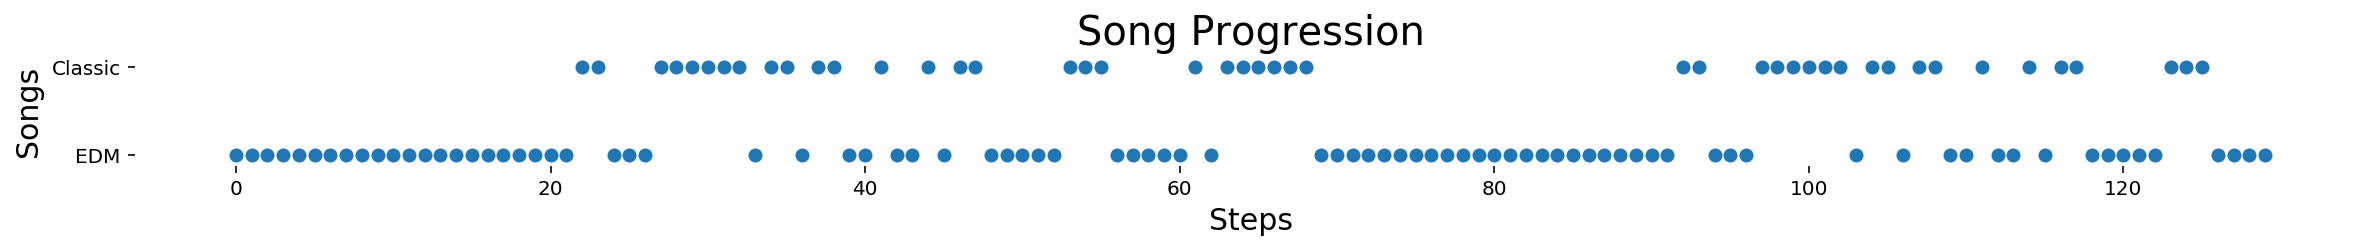

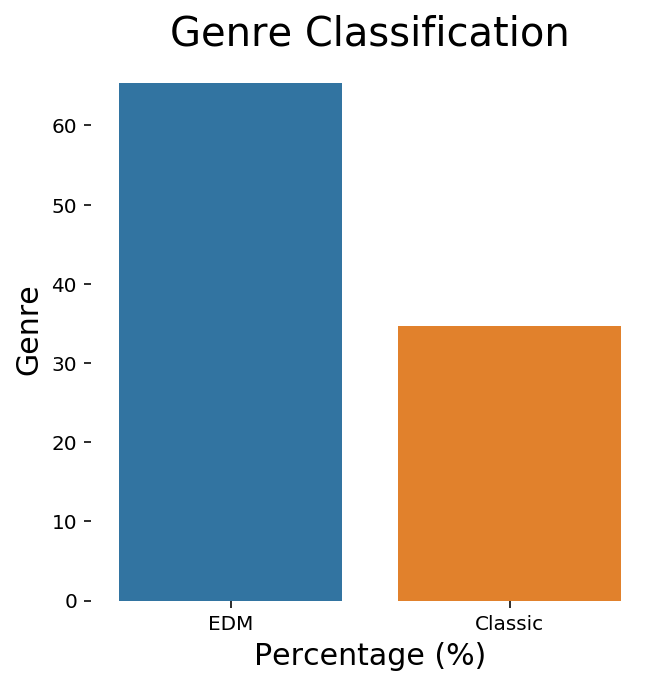

In [35]:
# Generate Visuals of Genre Classification and its Progression
plot_genre_progression(pred_label)
plot_genre_composition(pred_label)